### Evaluación de métricas y variables de los modelos lineales

In [1]:
import sys
sys.path.append("../../") # go to parent dir

In [2]:
from modelos import *
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import calplot
from pandas import DatetimeIndex

In [3]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

#### Cargamos los datos de las metricas de MLFlow para evaluar los modelos

In [4]:
runs = pd.read_csv('runs/runs-best.csv')
runs.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,activation,alpha,batch_size,hidden_layer_sizes,random_state,CV_TEST_RMSE,CV_TRAIN_RMSE,RANDOM SEED,TEST_MAX_ERROR,TEST_MEAN_ABS_ERROR,TEST_MEDIAN_ABS_ERROR,TEST_ROOT_MEAN_SQ_ERROR,Training Info,C,l1_ratio,loss,max_iter,selection,solver,bootstrap,max_depth,min_samples_leaf,min_samples_split,n_estimators
0,2024-04-28 21:29:27,6.0s,868cfe21feb841558a11f270a0a6392f,esc-X-mlp-random-search,LOCAL,C:\Users\dacoq\AppData\Roaming\Python\Python31...,dacoq,FINISHED,relu,0.2801,556.0,"(67, 93, 54)",NaN,0.263713,0.198438,777,2.512735,0.280249,0.197278,0.398988,Mejor modelo conseguido con RandomizedSearchCV...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-27 20:11:37,2.4s,2231e88727014ff684d0763fcc8a6c8b,MANUAL-selection-ELASTIC_random_search,LOCAL,/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/py...,tyomikjan,FINISHED,NaN,0.0100,NaN,NaN,777.0,0.453762,0.452350,777,2.524999,0.341155,0.274045,0.444501,Modelo elastic net,NaN,0.15,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-04-28 22:16:58,6.7s,c00c7aaa3a614762bd8110fcb260e756,esc_rf_con_random_search,LOCAL,C:\Users\dacoq\AppData\Roaming\Python\Python31...,dacoq,FINISHED,NaN,NaN,NaN,NaN,777.0,0.061150,0.024747,777,2.614159,0.273048,0.188845,0.388882,Random Forest donde los hiperparámetros se esc...,NaN,NaN,NaN,NaN,NaN,NaN,True,28.0,4.0,4.0,201.0


### RAIZ DE ECM por SUBCONJUNTOS

Pasamos a ver la diferencia entre el error (raiz del error cuadratico medio) de test de validación(CV_TEST_RMSE) con el error de train de validación (CV_TRAIN_RMSE) y el error sobre TEST (TEST_ROOT_MEAN_SQ_ERROR)

Text(0.5, 0, 'metros')

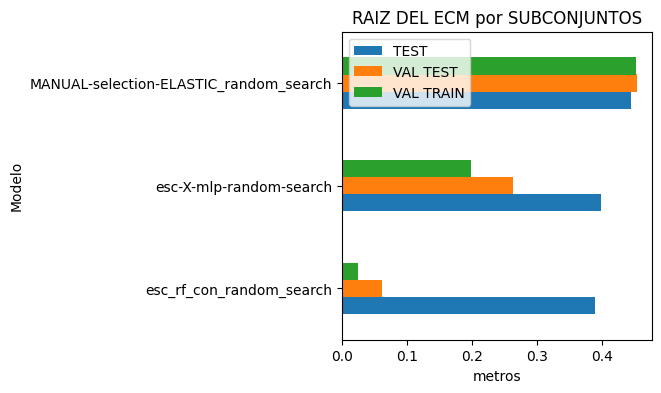

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
runs = runs.sort_values(by='TEST_ROOT_MEAN_SQ_ERROR')

runs.plot(x = 'Name', y = ['TEST_ROOT_MEAN_SQ_ERROR', 'CV_TEST_RMSE', 'CV_TRAIN_RMSE' ], kind = 'barh', ax=ax)
plt.legend(['TEST', 'VAL TEST', 'VAL TRAIN'], loc='upper left')
ax.set_title('RAIZ DEL ECM por SUBCONJUNTOS')
ax.set_ylabel('Modelo')
ax.set_xlabel('metros')

#### Vemos que el overfitting no le afecta tanto al modelo de elasticnet. Sin embargo, en el caso de random forest si se ve una clara presencia de overfitting.

### Otras métricas sobre el conjunto TEST

In [6]:
colors = ['gold', 'red', 'purple']
dictCol = dict(zip(runs.Name.unique(), colors))
runs['color'] = runs.Name.map(dictCol)

#### Error absoluto medio

Al no usar cuadrados y raices es una métrica más precisa del error

Text(0.5, 0, 'metros')

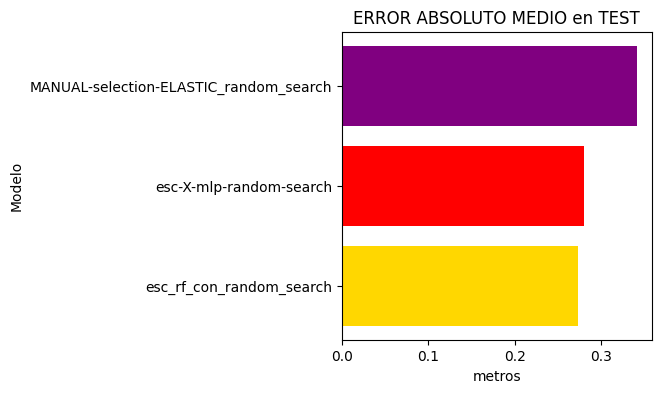

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
runs = runs.sort_values(by='TEST_MEAN_ABS_ERROR')

ax.barh(y = runs['Name'], width = runs['TEST_MEAN_ABS_ERROR'], color=runs.color)
ax.set_title('ERROR ABSOLUTO MEDIO en TEST')
ax.set_ylabel('Modelo')
ax.set_xlabel('metros')

En este caso vemos que varía bastante el rango de este error con respecto a la raiz de ECM, es menor (hasta 0,3 en vez de 0,4 para raiz de ECM)

#### Mediana del error absoluto

En vez de usar la media, usamos la mediana para que no afecten tanto los errores extremos

Text(0.5, 0, 'metros')

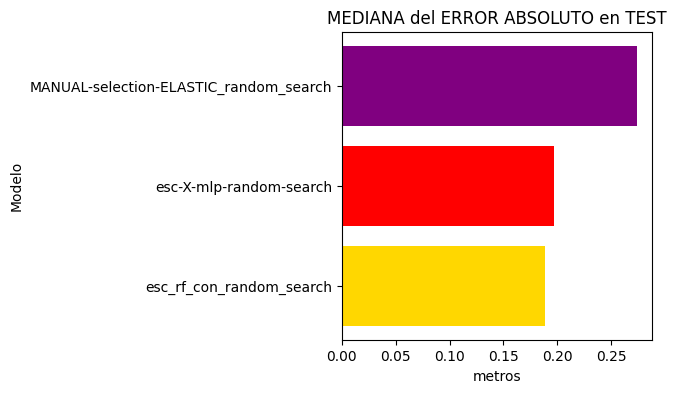

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
runs = runs.sort_values(by='TEST_MEDIAN_ABS_ERROR')

ax.barh(y = runs['Name'], width = runs['TEST_MEDIAN_ABS_ERROR'], color=runs.color)
ax.set_title('MEDIANA del ERROR ABSOLUTO en TEST')
ax.set_ylabel('Modelo')
ax.set_xlabel('metros')

En este caso también el rango baja respecto la anterior gráfica (no llega a 0,3 como en la anterior). Esto es lógico, pues en el anterior gráfico al coger la media se ve afectada por valores más extremos.

#### Error máximo:
Métrica importante y nos ayudará a tener en cuenta que modelos pueden funcionar mejor para predecir alturas de olas de todos los rangos

Text(0.5, 0, 'metros')

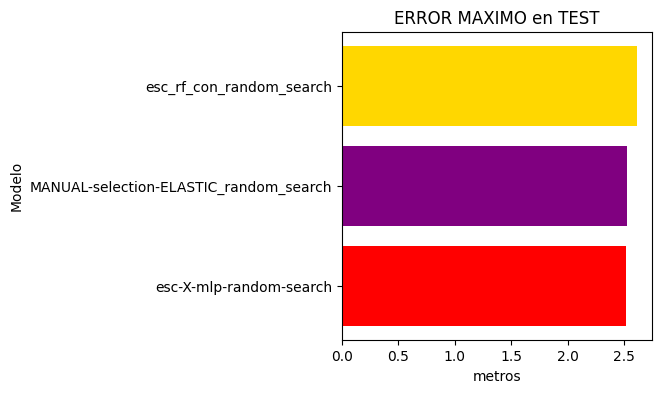

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
runs = runs.sort_values(by='TEST_MAX_ERROR')

ax.barh(y = runs['Name'], width = runs['TEST_MAX_ERROR'], color=runs.color)
ax.set_title('ERROR MAXIMO en TEST')
ax.set_ylabel('Modelo')
ax.set_xlabel('metros')

#### En general, los modelos son muy parecidos en las métricas, podríamos elegir el modelo de random forest, pues es lider en todas las métricas excepto el error máximo

### Análisis de gráficas de dispersión (Y_true vs Y_predicted) por segmentos (Alturas de olas)

In [11]:
# cargamos datos
X_train, X_test, y_train, y_test = sep_train_test()

##### Separamos las olas en 4 grupos por rangos de altura:

In [12]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

<Axes: title={'center': 'Segmentación de olas'}>

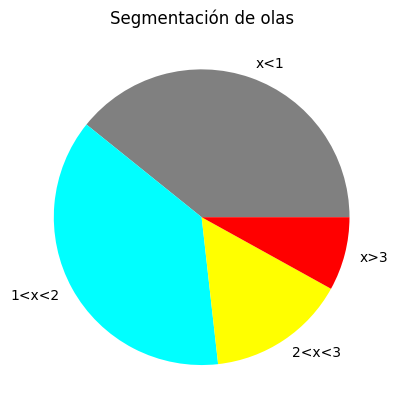

In [13]:
ola_clas = y_test.map(class_ola)
ola_clas.value_counts().plot(kind='pie', label='', title='Segmentación de olas', colors=['gray', "aqua", "yellow", "red"])

#### Funcion auxiliar para poder convertir el dataframe de test en uno lo que tiene que recibir el modelo como input

In [14]:
# Devuelve df_test modificado para que lo acepte el modelo m para hacer predict
def to_model_input(df_train, df_test, m):
    # Eliminamos las columnas repetidas y las columnas temporales (visto en el notebook del analisis)
    input_test = df_test.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
    input_train = df_train.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
    # if "auto" in m: no hay modelos automaticos, su rendimiento es muy bajo
    if "MANUAL" in m: # quitamos columnas
        cols = ['moonphase', 'temp', 'rh', 'pressure',
       'vis', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N',
       'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE',
       'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW',
       'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']
        input_test = input_test[cols]
        input_train = input_train[cols]
    if "esc" in m: # escalamos datos
        scaler = ColumnTransformer(
            transformers=[
                # no escalonamos las dummy de dirección de viento
                ("num", StandardScaler(), [c for c in input_train.columns if not c.startswith('wdir_')]),
            ],
            remainder='passthrough'
        )
        scaler.fit(input_train)
        input_test = scaler.transform(input_test)
    
    return input_test

#### Asignamos colores a los diferentes rangos para visualizar los segmentos en los graficos de dispersion

In [15]:
def ola_color(ola):
    if (ola < 1):
        return "gray"
    if (ola < 2):
        return "aqua"
    if (ola < 3):
        return "yellow"
    else:
        return "red" 

C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_late

Text(0.5, 0.98, 'Alturas de olas: PREDICTED vs TRUE')

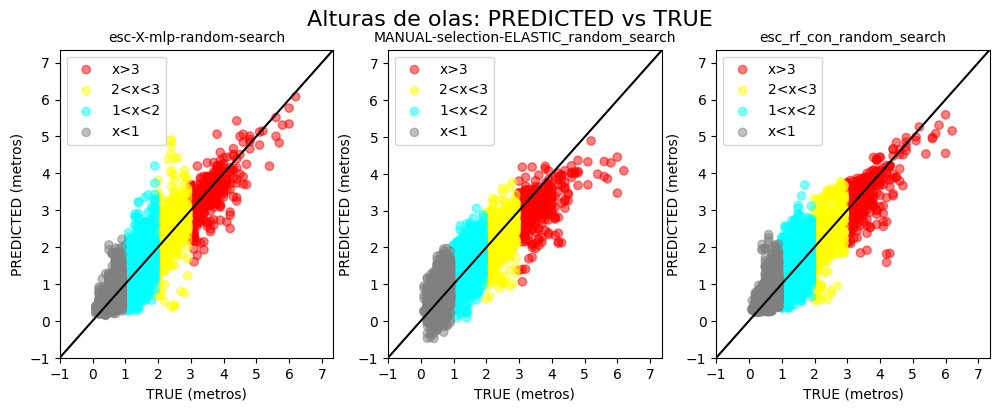

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i,m in enumerate(runs.Name):
    ax = axs[i]
    flo = MLFlow()
    # cargamos el modelo
    model = flo.get_saved_model(m)
    y_pred = model.predict(to_model_input(X_train, X_test, m))
    for cl in ola_clas.unique():
        filter = ola_clas == cl
        ax.scatter(y_test[filter], y_pred[filter], color=y_test[filter].map(ola_color), alpha=0.5)
    
    # nuestra recta - objetivo
    ax.axline((0, 0), (7, 7), color="0")
    ax.legend(["x>3", "2<x<3", "1<x<2", "x<1"], loc='upper left')
    ax.set_xlabel('TRUE (metros)')
    ax.set_ylabel('PREDICTED (metros)')
    ax.set_title(m, fontsize=10)
    ax.set_xticks(np.linspace(-1, 7, 9))
    ax.set_yticks(np.linspace(-1, 7, 9))

fig.suptitle('Alturas de olas: PREDICTED vs TRUE', fontsize=16)

Vemos que el modelo lineal es el único que llega a predecir olas negativas, lo cual se podria funcionar devolviendo el maximo entre la prediccion y el 0

`return np.maximum(y_pred, 0)`

Además, el modelo de redes neuronales se comporta mejor con olas de gran tamaño, aunque la dispersión de error sobre las predicciones es más alta.

Aun así, en general, siguen siendo muy parecidos en los gráficos de disperción.


#### Analisis de errores por dias

En esta sección analizaremos los errores viendolos como en un calendario

Primero vemos las distribuciones de olas por dias en nuestro conjunto TEST

Para ello primero definimos una función auxiliar para mostrar los datos en formato calendario

In [30]:
def plot_calendar(X_data, y_data, title, cmap = None, **kwargs):
    # unimos las columnas temporales con la y
    date_height_df = pd.concat([X_data[['anio', 'mes', 'dia', 'hora']].reset_index(drop=True), y_data.reset_index(drop=True)], axis=1)
    # renombramos las columnas para que se pueda convertir a datetimeindex
    date_height_df = date_height_df.rename({'anio': 'year', 'mes': 'month', 'dia': 'day', 'hora': 'hour'}, axis='columns')
    
    date_height_df.set_index(DatetimeIndex(pd.to_datetime(date_height_df[['year', 'month', 'day']])), inplace=True)
    # ya no necesitamos esta informacion, la tenemos en el indice
    date_height_df.drop(columns=['year', 'month', 'day'], inplace=True)
    
    # tenemos que agregar con la media porque son datos por hora y necesitamos los datos por dia
    date_height_df = date_height_df.groupby(date_height_df.index).agg({'AlturaOlas': 'mean'})
    if cmap is None:
        # para los colores https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
        cvals  = [0, 1, 2, 3]
        colors = ['gray', "aqua", "yellow", "red"]
        
        norm=plt.Normalize(min(cvals),max(cvals))
        tuples = list(zip(map(norm,cvals), colors))
        cmap = LinearSegmentedColormap.from_list("", tuples)
    # mostramos el grafico
    calplot.calplot(date_height_df.AlturaOlas,
                    suptitle = title,
                    suptitle_kws = {'x': 0.4, 'y': 1.0, 'fontsize': 16},
                    cmap=cmap,
                    figsize=(15,4),
                    **kwargs)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


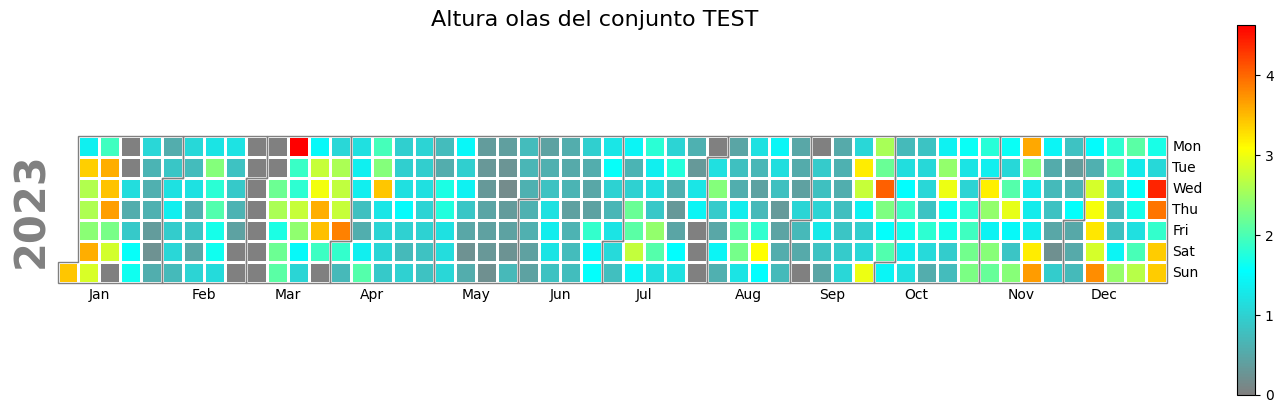

In [31]:
plot_calendar(X_test, y_test, 'Altura olas del conjunto TEST')

#### Vemos que las olas mayores de 3 metros se concentran principalmente en ENERO, MARZO y DICIEMBRE

#### Ahora pasamos a ver los errores del modelo cometidos en formato de calendario

#### El color azul significa que hemos SOBREESTIMADO la ola (subimos expectativas) y el color rojo que la hemos SUBESTIMADO (supone mayor riesgo al cliente)

##### Primero hacemos las graficas con colores que vayan del minimo al maximo para ver donde estan los mayores errores

C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://m

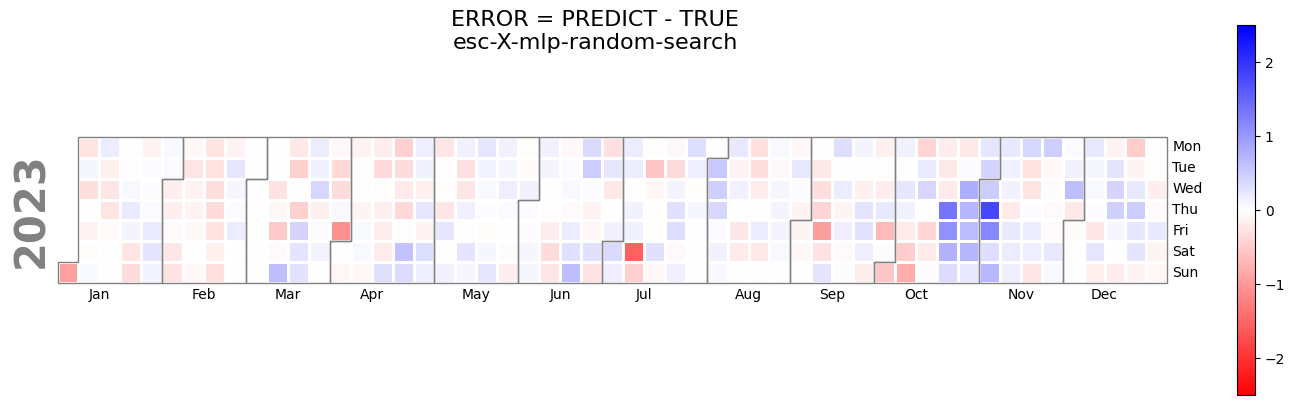

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


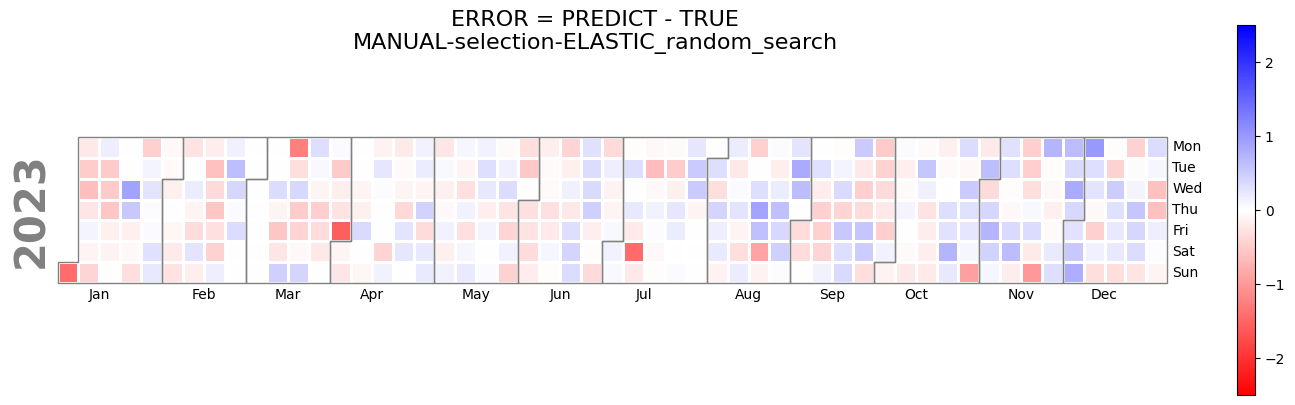

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


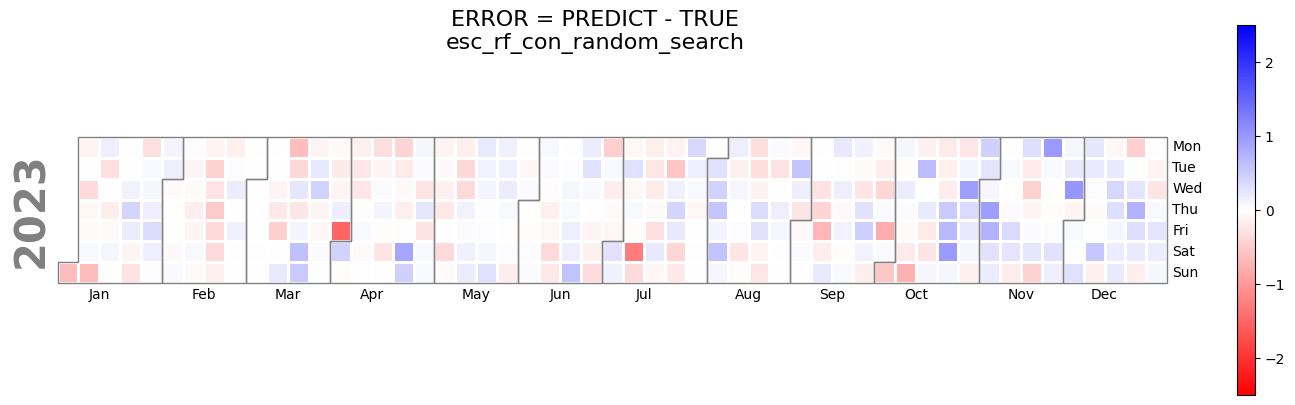

In [32]:

for i,m in enumerate(runs.Name):
    flo = MLFlow()
    # cargamos el modelo
    model = flo.get_saved_model(m)
    # pasamos numpy a Series
    y_pred = model.predict(to_model_input(X_train, X_test, m))
    
    diff = y_pred - y_test
    # para los colores https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
    cvals  = [-2.5, 0, 2.5]
    colors = ['red', '1', 'blue']
    
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plot_calendar(X_test, diff, 'ERROR = PREDICT - TRUE\n' + m, cmap, vmin=-2.5, vmax=2.5)


Vemos que el modelo lineal tiene más fallos extremos de subestimación (rojo) que los otros dos. Por otro lado, el modelo de mlp tiene más errores de sobreestimación (azul).

El modelo de random forest es el más estable en este sentido.

C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
C:\Users\dacoq\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://m

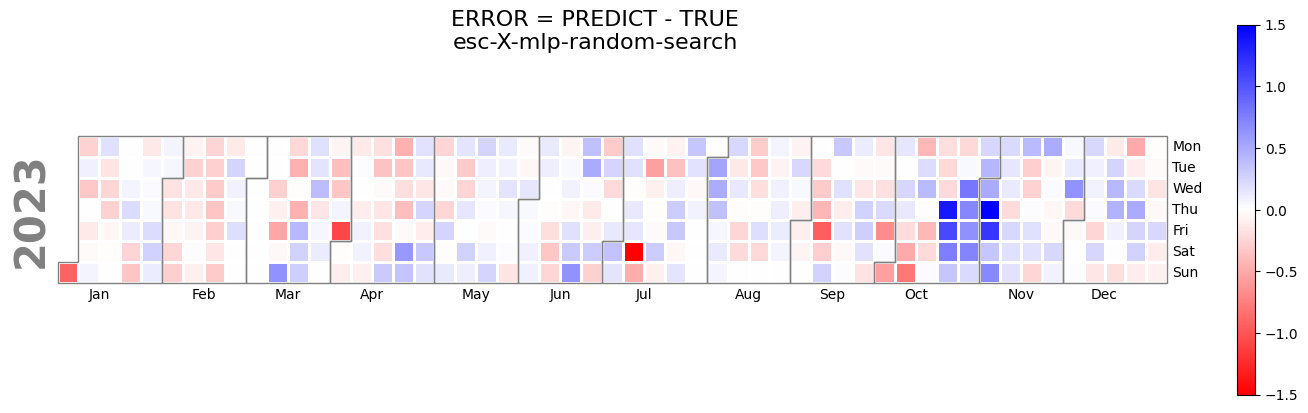

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


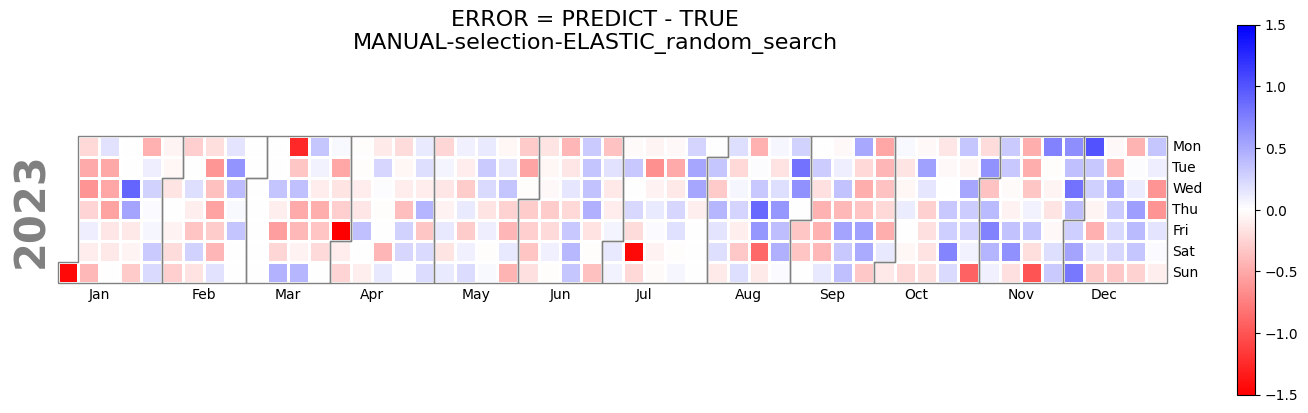

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


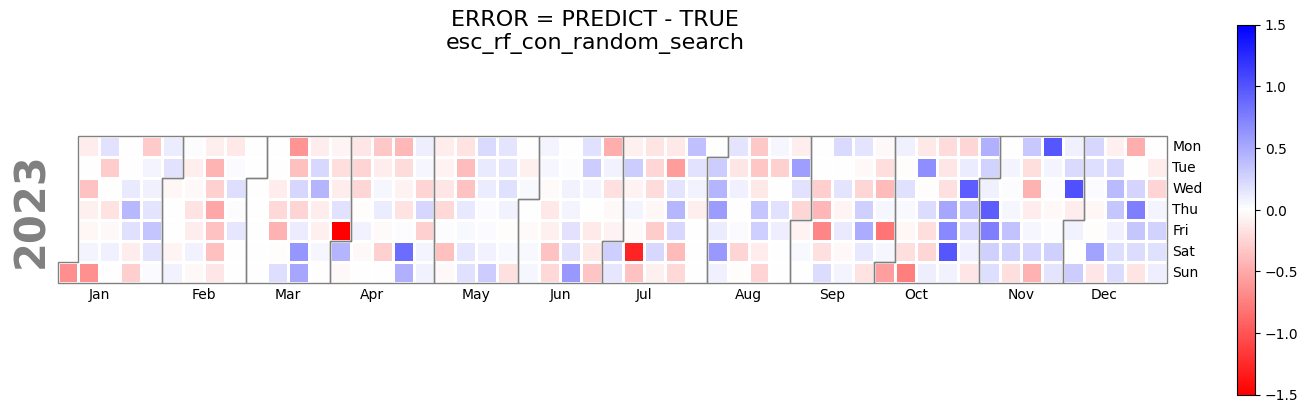

In [33]:

for i,m in enumerate(runs.Name):
    flo = MLFlow()
    # cargamos el modelo
    model = flo.get_saved_model(m)
    # pasamos numpy a Series
    y_pred = model.predict(to_model_input(X_train, X_test, m))
    
    diff = y_pred - y_test
    # para los colores https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
    cvals  = [-2.5, 0, 2.5]
    colors = ['red', '1', 'blue']
    
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plot_calendar(X_test, diff, 'ERROR = PREDICT - TRUE\n' + m, cmap, vmin=-1.5, vmax=1.5)


### CONCLUSION

Como los tres modelos tienen métricas muy parecidas es complicado decidirse por uno en concreto. En nuesto caso, decidimos considerar nuestro modelo definitivo el de random_forest con los datos escalados porque creemos que aporta mayor precisión ante olas extremas que son muy importantes predecirlas bien para el objetivo del negocio.